# Tutorial 1 - Intro to neural ODE based Neural Networks
The goal of this tutorial is to get familiar with the fundamentals of the code basis and ensure it is running  
The notebook utilizes code from the package torchdiffeq and Borjan Geshkovski https://github.com/borjanG/2021-dynamical-systems

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt



# Juptyer magic: For export. Makes the plots size right for the screen
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Data preparation

Data point of X: [ 0.82082754 -1.65417398] 
Data type X: float64

Data point of y: 1 
Data type y: float64


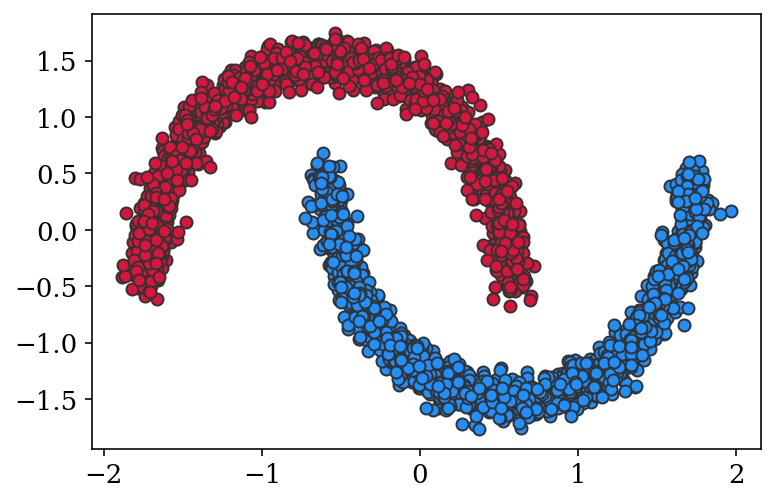

In [15]:
#We load a typical toy dataset that requires a nonlinear classification model to achieve high accuracy
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#the noise describes how large the standard deviation of the data distribution is
noise = 0.05

#Load 3000 instances of data points

X, y = make_moons(n_samples = 3000, noise = noise)

X = StandardScaler().fit_transform(X)
#alternative toy data set
# X, y = make_circles(3000, noise=noise, factor=0.15)


print('Data point of X:', X[0], '\nData type X:', X.dtype)
print('\nData point of y:', y[0], '\nData type y:', X.dtype)

#Visualizing the data
data_0 = X[y == 0]
data_1 = X[y == 1]
fig = plt.figure()
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", color = 'crimson')
plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", color = 'dodgerblue')
plt.show()

As typical for machine learning algorithms, we split the data into a training set and test set.  
To use the pytorch frameset, we recast the data as tensors and create Dataloaders used to conveniently load the training and test data during training and validation.

In [16]:
from torch.utils.data import DataLoader,TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2 )

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64)
dataloader_viz = DataLoader(test, batch_size=128)

In [17]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-0.2177, -0.9920],
        [ 0.5684,  0.2885],
        [-0.3926,  1.6435],
        [ 0.8357, -1.3836],
        [ 1.5086, -0.4093],
        [-0.4922, -0.2267],
        [ 1.4881, -0.5085],
        [-0.1726, -1.1651],
        [-1.7714,  0.1905],
        [-0.5358,  1.4597]]) tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0])


# Model dynamics

In [41]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5.0, 10  
dt = T/num_steps
bound = 0.
fp = False
cross_entropy = True


# non_linearity = 'relu'
non_linearity = 'tanh' 
# architecture = 'bottleneck' 
architecture = 'outside'

v_steps = 5
training = True #train new network or load saved one

anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 
print(anode)


NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [42]:
from models.training import Trainer

trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                         bound=bound, fixed_projector=fp, verbose = True) 

print("Model's state_dict:")
for param_tensor in anode.state_dict():
    print(param_tensor, "\t", anode.state_dict()[param_tensor].size())

Model's state_dict:
flow.dynamics.fc2_time.0.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.0.bias 	 torch.Size([2])
flow.dynamics.fc2_time.1.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.1.bias 	 torch.Size([2])
flow.dynamics.fc2_time.2.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.2.bias 	 torch.Size([2])
flow.dynamics.fc2_time.3.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.3.bias 	 torch.Size([2])
flow.dynamics.fc2_time.4.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.4.bias 	 torch.Size([2])
flow.dynamics.fc2_time.5.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.5.bias 	 torch.Size([2])
flow.dynamics.fc2_time.6.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.6.bias 	 torch.Size([2])
flow.dynamics.fc2_time.7.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.7.bias 	 torch.Size([2])
flow.dynamics.fc2_time.8.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_time.8.bias 	 torch.Size([2])
flow.dynamics.fc2_time.9.weight 	 torch.Size([2, 2])
flow.dynamics.fc2_

In [43]:
num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
trainer_anode.train(dataloader, num_epochs)

/home/np1/staff/woehrer/FAUbox/Python/borjan dynamical.systems/models/training.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)



Epoch 0/38
Loss: 0.927
Accuracy: 0.344

Epoch 10/38
Loss: 0.843
Accuracy: 0.422

Epoch 20/38
Loss: 0.793
Accuracy: 0.391

Epoch 30/38
Loss: 0.781
Accuracy: 0.375
Epoch 1: 0.839

Epoch 0/38
Loss: 0.800
Accuracy: 0.375

Epoch 10/38
Loss: 0.738
Accuracy: 0.469

Epoch 20/38
Loss: 0.713
Accuracy: 0.484

Epoch 30/38
Loss: 0.713
Accuracy: 0.422
Epoch 2: 0.743

Epoch 0/38
Loss: 0.722
Accuracy: 0.438

Epoch 10/38
Loss: 0.674
Accuracy: 0.453

Epoch 20/38
Loss: 0.662
Accuracy: 0.484

Epoch 30/38
Loss: 0.665
Accuracy: 0.422
Epoch 3: 0.678

Epoch 0/38
Loss: 0.665
Accuracy: 0.453

Epoch 10/38
Loss: 0.625
Accuracy: 0.578

Epoch 20/38
Loss: 0.621
Accuracy: 0.578

Epoch 30/38
Loss: 0.625
Accuracy: 0.500
Epoch 4: 0.626

Epoch 0/38
Loss: 0.615
Accuracy: 0.578

Epoch 10/38
Loss: 0.580
Accuracy: 0.703

Epoch 20/38
Loss: 0.584
Accuracy: 0.641

Epoch 30/38
Loss: 0.587
Accuracy: 0.562
Epoch 5: 0.578

Epoch 0/38
Loss: 0.566
Accuracy: 0.719

Epoch 10/38
Loss: 0.535
Accuracy: 0.781

Epoch 20/38
Loss: 0.545
Accu

## Generate a gif of the evolution of the input points through the neural network

In [44]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

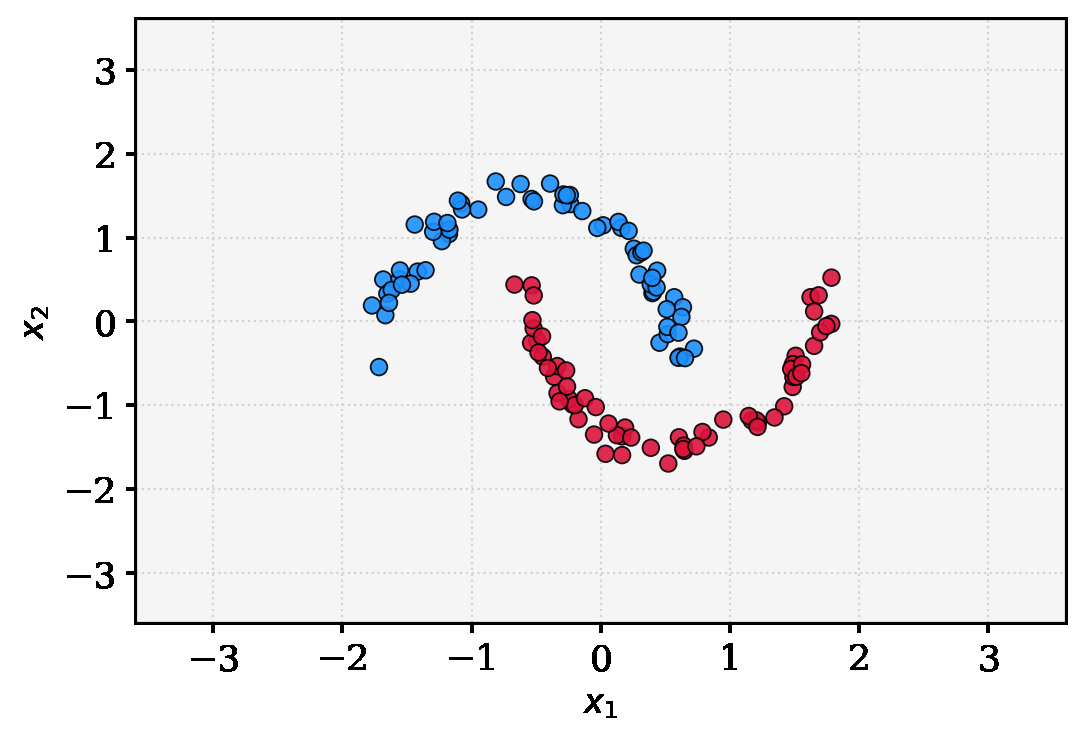

In [45]:
#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory.gif", retina = True)

Observe that the blue and red data points are getting seperated further as time passes which corresponds to a sucessfull classification.

In [50]:
from models.training import doublebackTrainer

eps = 0.3


# non_linearity = 'tanh'  # 'sigmoid' #'tanh'
# architecture = 'outside'  # outside #bottleneck

    
    
    
    
node = NeuralODE(device, data_dim, hidden_dim, adjoint=False, augment_dim=0, non_linearity=non_linearity,
                            architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
        # if pretrained:
        #     node.load_state_dict(torch.load('rob_node.pth'))


optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-3)  # weight decay parameter modifies norm
       
          
trainer_eps_node = doublebackTrainer(node, optimizer_node, device, cross_entropy=cross_entropy,
                                        bound=bound, fixed_projector=fp, verbose=True, eps=eps, l2_factor = 0)


In [51]:
# num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
trainer_eps_node.train(dataloader, num_epochs)


Epoch 0/38
Loss: 1.144
Accuracy: 0.203

Epoch 10/38
Loss: 1.078
Accuracy: 0.188

Epoch 20/38
Loss: 1.010
Accuracy: 0.297

Epoch 30/38
Loss: 0.972
Accuracy: 0.375
Epoch 1: 1.071

Epoch 0/38
Loss: 0.982
Accuracy: 0.359

Epoch 10/38
Loss: 0.931
Accuracy: 0.406

Epoch 20/38
Loss: 0.891
Accuracy: 0.469

Epoch 30/38
Loss: 0.881
Accuracy: 0.484
Epoch 2: 0.937

Epoch 0/38
Loss: 0.885
Accuracy: 0.484

Epoch 10/38
Loss: 0.842
Accuracy: 0.562

Epoch 20/38
Loss: 0.818
Accuracy: 0.562

Epoch 30/38
Loss: 0.827
Accuracy: 0.484
Epoch 3: 0.856

Epoch 0/38
Loss: 0.825
Accuracy: 0.484

Epoch 10/38
Loss: 0.787
Accuracy: 0.562

Epoch 20/38
Loss: 0.773
Accuracy: 0.562

Epoch 30/38
Loss: 0.792
Accuracy: 0.484
Epoch 4: 0.806

Epoch 0/38
Loss: 0.787
Accuracy: 0.484

Epoch 10/38
Loss: 0.750
Accuracy: 0.562

Epoch 20/38
Loss: 0.742
Accuracy: 0.562

Epoch 30/38
Loss: 0.767
Accuracy: 0.484
Epoch 5: 0.771

Epoch 0/38
Loss: 0.758
Accuracy: 0.484

Epoch 10/38
Loss: 0.723
Accuracy: 0.562

Epoch 20/38
Loss: 0.719
Accu

In [52]:
for X_viz, y_viz in dataloader_viz:
    trajectory_gif(node, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif')
    break

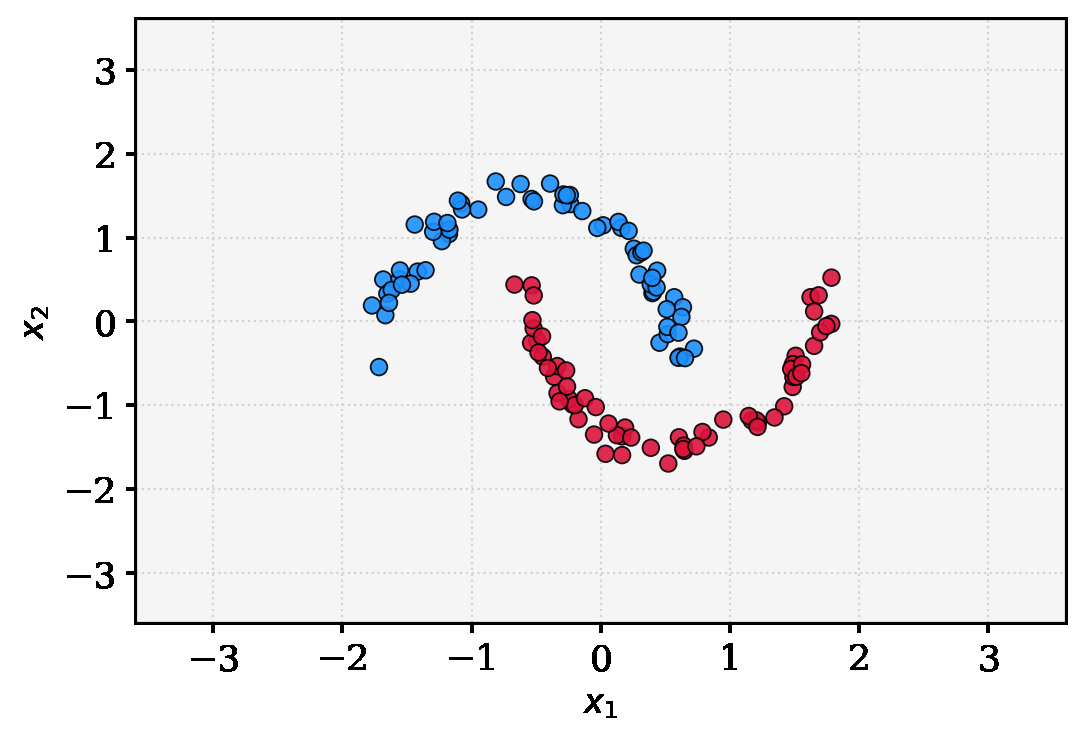

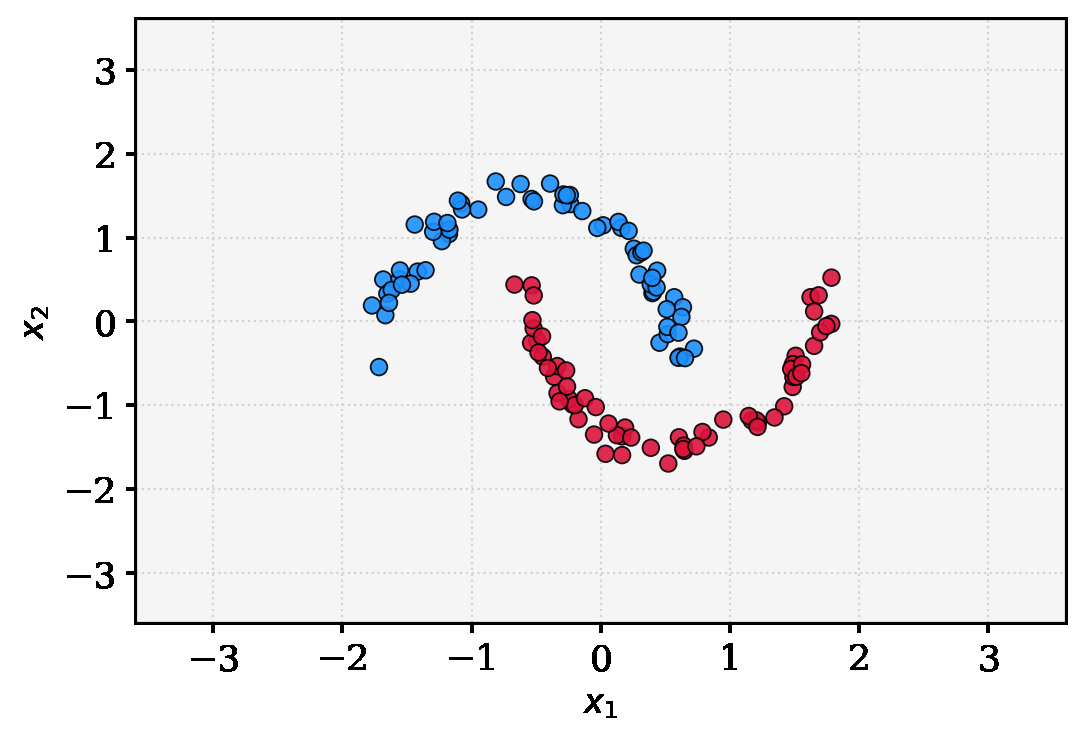

In [53]:
#Display of the generated gif

from IPython.display import Image, display
# Image(filename="trajectory.gif", retina = True)
img1 = Image(filename="trajectory_db.gif", retina = True)
img2 = Image(filename="trajectory.gif", retina = True)

display(img1, img2)